# Imports and Setup

In [ ]:
import pandas as pd
import numpy as np
import kagglehub
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.svm import SVC

import seaborn as sns

# warnings.filterwarnings("ignore")

# Dataset Loading

In [ ]:
# Load FinBERT sentiment data
df_tweets = pd.read_csv("/content/df_tweets_finbert.csv")

# Convert string datetime if necessary
df_tweets['Date'] = pd.to_datetime(df_tweets['Date'])

# Compute polarity score: positive - negative
df_tweets["sentiment"] = df_tweets["positive"] - df_tweets["negative"]

# Optional: classify sentiment
def classify_sentiment(score):
    if score > 0.05:
        return "Positive"
    elif score < -0.05:
        return "Negative"
    else:
        return "Neutral"

df_tweets["sentiment_label"] = df_tweets["sentiment"].apply(classify_sentiment)


In [ ]:
df_tweets.head()

,Unnamed: 0,Date,Tweet,Stock Name,Company Name,sentiment_scores,positive,negative,neutral,sentiment,sentiment_label
0,0,2022-09-29 23:41:16+00:00,Mainstream media has done an amazing job at br...,TSLA,"Tesla, Inc.",[0.17608453 0.05474913 0.76916635],0.176085,0.054749,0.769166,0.121335,Positive
1,1,2022-09-29 23:24:43+00:00,Tesla delivery estimates are at around 364k fr...,TSLA,"Tesla, Inc.",[0.03738248 0.02211765 0.94049984],0.037382,0.022118,0.940500,0.015265,Neutral
2,2,2022-09-29 23:18:08+00:00,3/ Even if I include 63.0M unvested RSUs as of...,TSLA,"Tesla, Inc.",[0.04879288 0.02022232 0.93098474],0.048793,0.020222,0.930985,0.028571,Neutral
3,3,2022-09-29 22:40:07+00:00,@RealDanODowd @WholeMarsBlog @Tesla Hahaha why...,TSLA,"Tesla, Inc.",[0.05117656 0.11496431 0.83385915],0.051177,0.114964,0.833859,-0.063788,Negative
4,4,2022-09-29 22:27:05+00:00,"@RealDanODowd @Tesla Stop trying to kill kids,...",TSLA,"Tesla, Inc.",[0.02711585 0.6897208 0.28316334],0.027116,0.689721,0.283163,-0.662605,Negative


In [ ]:
# Downloading finance data
path = kagglehub.dataset_download("equinxx/stock-tweets-for-sentiment-analysis-and-prediction")

print("Path to dataset files:", path)

df_finance = pd.read_csv(f'{path}/stock_yfinance_data.csv')
df_finance.head()

Path to dataset files: /kaggle/input/stock-tweets-for-sentiment-analysis-and-prediction


,Date,Open,High,Low,Close,Adj Close,Volume,Stock Name
0,2021-09-30,260.333344,263.043335,258.333344,258.493347,258.493347,53868000,TSLA
1,2021-10-01,259.466675,260.260010,254.529999,258.406677,258.406677,51094200,TSLA
2,2021-10-04,265.500000,268.989990,258.706665,260.510010,260.510010,91449900,TSLA
3,2021-10-05,261.600006,265.769989,258.066681,260.196655,260.196655,55297800,TSLA
4,2021-10-06,258.733337,262.220001,257.739990,260.916656,260.916656,43898400,TSLA


# Preprocessing

In [ ]:
df_tweets['Date'] = pd.to_datetime(df_tweets['Date']).dt.date
df_finance['Date'] = pd.to_datetime(df_finance['Date']).dt.date

# Finding Correlated Data

In [ ]:
# Create a pivot table just for correlation analysis
pivot_close = df_finance.pivot(index='Date', columns='Stock Name', values='Close')

In [ ]:
# Compute absolute correlation matrix
correlation_matrix = pivot_close.corr().abs()

# Get upper triangle
upper_triangle = correlation_matrix.where(np.triu(np.ones(correlation_matrix.shape), k=1).astype(bool))

# Define threshold and identify stocks to drop
threshold = 0.95
to_drop = [col for col in upper_triangle.columns if any(upper_triangle[col] > threshold)]

print("Dropped stocks due to high correlation:", to_drop)

Dropped stocks due to high correlation: ['MSFT', 'NFLX']


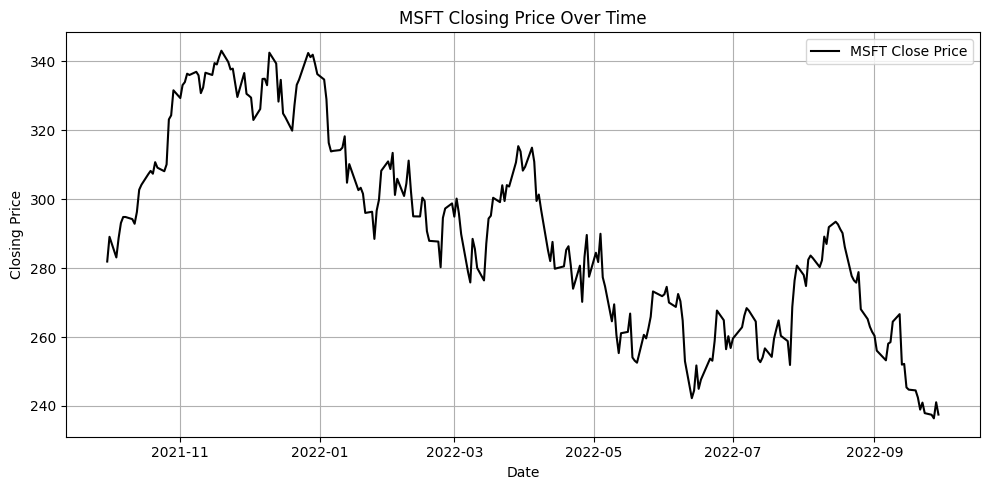

In [ ]:
df_msft = df_finance[df_finance['Stock Name'] == 'MSFT']
# Plot the closing price over time
plt.figure(figsize=(10, 5))
plt.plot(df_msft['Date'], df_msft['Close'], label='MSFT Close Price', color='black')
plt.title("MSFT Closing Price Over Time")
plt.xlabel("Date")
plt.ylabel("Closing Price")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

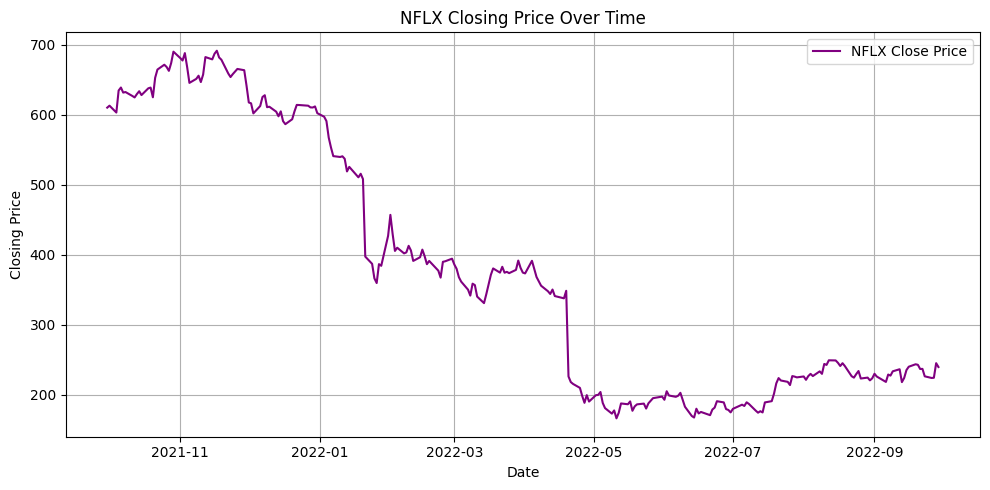

In [ ]:
df_netflix = df_finance[df_finance['Stock Name'] == 'NFLX']
# Plot the closing price over time
plt.figure(figsize=(10, 5))
plt.plot(df_netflix['Date'], df_netflix['Close'], label='NFLX Close Price', color='purple')
plt.title("NFLX Closing Price Over Time")
plt.xlabel("Date")
plt.ylabel("Closing Price")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

In [ ]:
# Keep only stocks that are not in the drop list
filtered_df = df_finance[~df_finance['Stock Name'].isin(to_drop)]

In [ ]:
df_finance = filtered_df
df_finance.head()

,Date,Open,High,Low,Close,Adj Close,Volume,Stock Name
0,2021-09-30,260.333344,263.043335,258.333344,258.493347,258.493347,53868000,TSLA
1,2021-10-01,259.466675,260.260010,254.529999,258.406677,258.406677,51094200,TSLA
2,2021-10-04,265.500000,268.989990,258.706665,260.510010,260.510010,91449900,TSLA
3,2021-10-05,261.600006,265.769989,258.066681,260.196655,260.196655,55297800,TSLA
4,2021-10-06,258.733337,262.220001,257.739990,260.916656,260.916656,43898400,TSLA


In [ ]:
# Aggregate the data based on the date
daily_sentiment = df_tweets.groupby(['Date', 'Stock Name'])['sentiment'].mean().reset_index()
daily_sentiment.columns = ['Date', 'Ticker', 'Avg_Sentiment']

df_finance.rename(columns={'Stock Name': 'Ticker'}, inplace=True)

daily_sentiment['Ticker'] = daily_sentiment['Ticker'].astype(str)
df_finance['Ticker'] = df_finance['Ticker'].astype(str)

merged = pd.merge(df_finance, daily_sentiment, on=['Date', 'Ticker'], how='inner')

In [ ]:
results = []

for ticker in merged['Ticker'].unique():
    data = merged[merged['Ticker'] == ticker].copy()
    data = data.sort_values('Date')
    data['Target'] = (data['Close'].shift(-1) > data['Close']).astype(int)
    data.dropna(inplace=True)

    X = data[['Avg_Sentiment']]
    y = data['Target']

    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, shuffle=False)

    svm = SVC(kernel='rbf', C=1.0, gamma='auto')
    svm.fit(X_train, y_train)

    y_pred = svm.predict(X_test)
    acc = accuracy_score(y_test, y_pred)

    results.append({'Ticker': ticker, 'Accuracy': acc, 'Report': classification_report(y_test, y_pred, output_dict=True)})

for res in results:
    print(f"Stock: {res['Ticker']} - Accuracy: {res['Accuracy']:.2f}")


Stock: TSLA - Accuracy: 0.51
Stock: PG - Accuracy: 0.59
Stock: META - Accuracy: 0.45
Stock: AMZN - Accuracy: 0.49
Stock: GOOG - Accuracy: 0.40
Stock: AMD - Accuracy: 0.48
Stock: AAPL - Accuracy: 0.43
Stock: TSM - Accuracy: 0.59
Stock: KO - Accuracy: 0.56
Stock: F - Accuracy: 0.20
Stock: COST - Accuracy: 0.44
Stock: DIS - Accuracy: 0.51
Stock: VZ - Accuracy: 0.69
Stock: CRM - Accuracy: 0.54
Stock: INTC - Accuracy: 0.48
Stock: BA - Accuracy: 0.48
Stock: BX - Accuracy: 0.17
Stock: NOC - Accuracy: 0.20
Stock: PYPL - Accuracy: 0.55
Stock: ENPH - Accuracy: 0.39
Stock: NIO - Accuracy: 0.53
Stock: ZS - Accuracy: 0.43
Stock: XPEV - Accuracy: 0.53


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/m

Accuracy: 0.5

Classification Report:
               precision    recall  f1-score   support

           0       0.51      0.40      0.45       586
           1       0.50      0.60      0.54       574

    accuracy                           0.50      1160
   macro avg       0.50      0.50      0.50      1160
weighted avg       0.50      0.50      0.49      1160



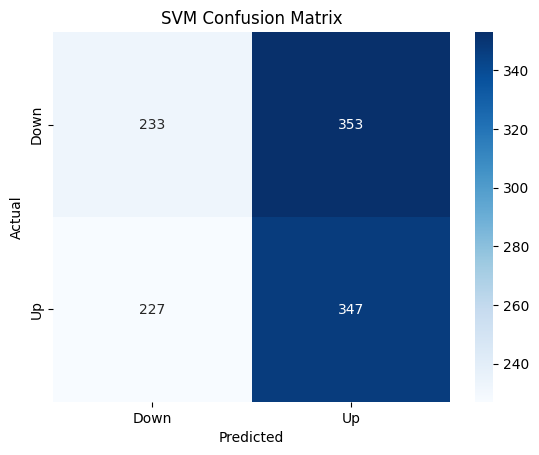

In [ ]:
# Aggregate sentiment per day
daily_sentiment = df_tweets.groupby('Date')['sentiment'].mean().reset_index()
daily_sentiment.columns = ['Date', 'Avg_Sentiment']

# Merge with stock data
merged = pd.merge(df_finance, daily_sentiment, on='Date', how='inner')
merged = merged.sort_values('Date')

merged['Target'] = (merged['Close'].shift(-1) > merged['Close']).astype(int)
merged.dropna(inplace=True)

# Features and labels
X = merged[['Avg_Sentiment']]
y = merged['Target']

# Scale the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, shuffle=False)

svm = SVC(kernel='rbf', C=1.0, gamma='auto')
svm.fit(X_train, y_train)
y_pred = svm.predict(X_test)

print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))

# Confusion matrix
conf_mat = confusion_matrix(y_test, y_pred)
sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues', xticklabels=['Down', 'Up'], yticklabels=['Down', 'Up'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('SVM Confusion Matrix')
plt.show()

Initial Balance: $10000.00
Final Balance: $10784.72
Total Profit: $784.72
Return: 7.85%


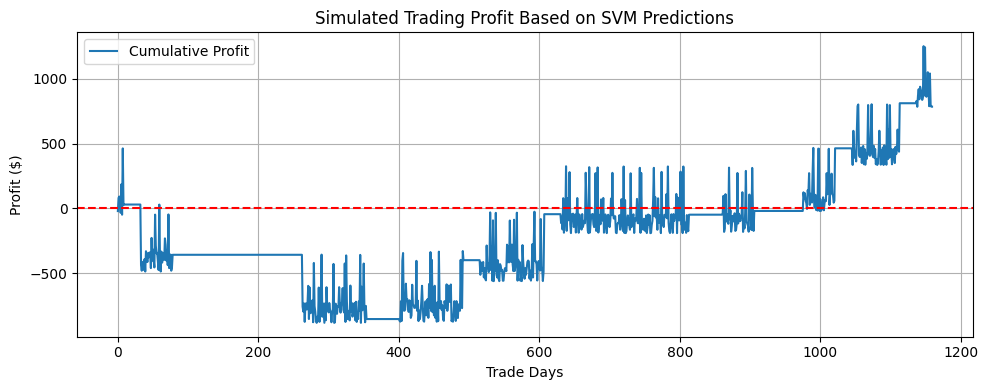

In [ ]:
test_dates = merged.iloc[len(X_train):].reset_index(drop=True)

initial_balance = 10000
balance = initial_balance
positions = []
profits = []

for i in range(len(y_pred)):
    if y_pred[i] == 1:
        buy_price = test_dates.iloc[i]['Close']
        if i + 1 < len(test_dates):
            sell_price = test_dates.iloc[i + 1]['Close']
            profit = (sell_price - buy_price)
            balance += profit
            profits.append(profit)
            positions.append(1)
        else:
            profits.append(0)
            positions.append(0)
    else:
        profits.append(0)
        positions.append(0)

total_profit = sum(profits)
return_percent = (balance - initial_balance) / initial_balance * 100

print(f"Initial Balance: ${initial_balance:.2f}")
print(f"Final Balance: ${balance:.2f}")
print(f"Total Profit: ${total_profit:.2f}")
print(f"Return: {return_percent:.2f}%")

cumulative_profit = np.cumsum(profits)
plt.figure(figsize=(10, 4))
plt.plot(cumulative_profit, label='Cumulative Profit')
plt.axhline(0, color='red', linestyle='--')
plt.title('Simulated Trading Profit Based on SVM Predictions')
plt.xlabel('Trade Days')
plt.ylabel('Profit ($)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


Mean Reversion + Sentiment Strategy Results
Initial Balance: $10000.00
Final Balance: $43263.19
Total Profit: $33263.19
Return: 332.63%


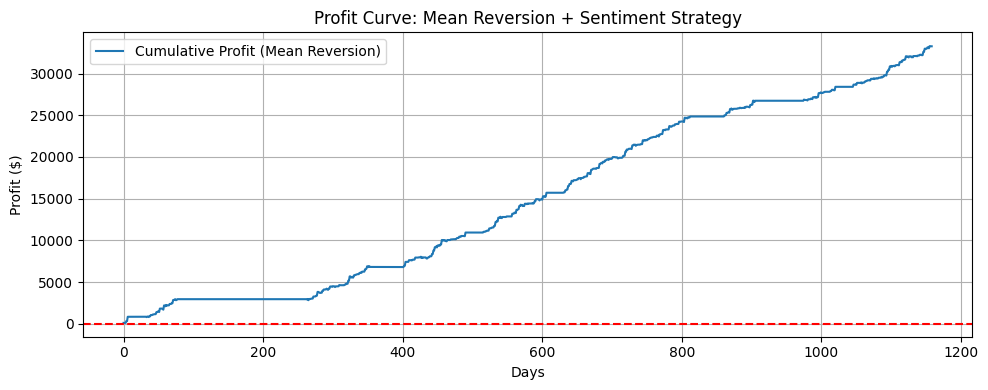

In [ ]:
# Preprocessing for mean reversion

merged['MA5'] = merged['Close'].rolling(window=5).mean()

merged.dropna(inplace=True)
X = merged[['Avg_Sentiment']]
y = (merged['Close'].shift(-1) > merged['Close']).astype(int)
X_scaled = scaler.fit_transform(X)
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, shuffle=False)

# Train generic svm model

svm = SVC(kernel='rbf', C=1.0, gamma='auto')
svm.fit(X_train, y_train)
y_pred = svm.predict(X_test)

test_data = merged.iloc[len(X_train):].reset_index(drop=True)

# Running mean reversion on the test data

initial_balance = 10000
balance = initial_balance
profits = []
positions = []

for i in range(len(y_pred)):
    today_price = test_data.iloc[i]['Close']
    ma5 = test_data.iloc[i]['MA5']

    # Strategy: Buy only if predicted up AND price < MA5
    if y_pred[i] == 1 and today_price < ma5:
        if i + 1 < len(test_data):
            next_price = test_data.iloc[i + 1]['Close']
            profit = next_price - today_price
            balance += profit
            profits.append(profit)
            positions.append(1)
        else:
            profits.append(0)
            positions.append(0)
    else:
        profits.append(0)
        positions.append(0)

total_profit = sum(profits)
return_percent = (balance - initial_balance) / initial_balance * 100

# Results

print(f"Mean Reversion + Sentiment Strategy Results")
print(f"Initial Balance: ${initial_balance:.2f}")
print(f"Final Balance: ${balance:.2f}")
print(f"Total Profit: ${total_profit:.2f}")
print(f"Return: {return_percent:.2f}%")

cumulative_profit = np.cumsum(profits)
plt.figure(figsize=(10, 4))
plt.plot(cumulative_profit, label='Cumulative Profit (Mean Reversion)')
plt.axhline(0, color='red', linestyle='--')
plt.title('Profit Curve: Mean Reversion + Sentiment Strategy')
plt.xlabel('Days')
plt.ylabel('Profit ($)')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()